#**Classification (Supervised Learning) - Using conventional ML models**

**Aim**: The objective is to study and examine the Trust pilot reviews sentiments on [TrustPilot](https://www.trustpilot.com/review/www.wexphotovideo.com) of Wex Photo Video using NLP. The data to be extracted and then existing conventional supervised models to be applied. The results to be observed and evaluated.  


In [2]:
# Mounted data on drive so that it doesn't require upload every time google colab is loaded
from google.colab import drive
drive.mount('/content/CFA_Wex', force_remount= True)

Mounted at /content/CFA_Wex


##### **Installing Dependencies**

In [2]:
!pip install contractions
!pip install demoji

!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##### **Required Python Libraries**

In [3]:
# Scraping Libraries
import os
import time
import requests
import csv
import json
import re
from bs4 import BeautifulSoup
from datetime import datetime

# Dataset Libraries
import pandas as pd
import numpy as np

# Preprocessing Libraries
import contractions
import string
import spacy
import demoji
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

# Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
pd.options.display.max_rows = 10
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
print("Setup complete.")

Setup complete.


In [4]:
# ML Libraries
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed

##### **Store path into a global variable**

In [5]:
path = os.getcwd() + '/CFA_Wex/MyDrive/'

**The dataset contains more neutral data collected from other resources from Kaggle.**

**References:-**

**Kaggle Company Reviews Dataset**

Reference: https://www.kaggle.com/competitions/sentiment-analysis-company-reviews/rules

**Kaggle Women's E-Commerce Clothing Review Dataset**

Reference: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [6]:
combined_df = pd.read_csv(path + '/combined_data_7000.csv')

In [7]:
combined_df.head()

,Rating,Content,Source,sentiment
0,4.0,Not sure yet. Don't have the item,PowerReviews,2
1,4.0,It would be nice if I could finish shopping be...,PowerReviews,2
2,4.0,"Seemless, so far. Need to wait for delivery to...",PowerReviews,2
3,4.0,Website slow.,PowerReviews,2
4,4.0,EASY TO USE ONLINE SYSTEM,PowerReviews,2


In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378 entries, 0 to 21377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rating     21378 non-null  float64
 1   Content    21378 non-null  object 
 2   Source     21378 non-null  object 
 3   sentiment  21378 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 668.2+ KB


In [9]:
combined_df['Rating'].value_counts()

Rating
3.0    7131
4.0    3628
1.0    3607
5.0    3599
2.0    3413
Name: count, dtype: int64

In [10]:
combined_df['Source'].value_counts()

Source
PowerReviews    7347
Trustpilot      5401
Kaggle Comp     5229
Kaggle Ecom     3401
Name: count, dtype: int64

## **Data Cleansing, Sampling and Balancing**

## **Targets**

*   Handling Missing Values ✅
*   Remove Constant Features ✅
*   Data Balancing ✅

#### **Handling Missing Values**

In [ ]:
combined_df.isnull().sum()

Rating       0
Content      0
Source       0
sentiment    0
dtype: int64

**Data is already free from NaN / missing values**



#### **Remove Constant Features**
*   Find out features which are constant.
*   Constant meaning the features which contains only single type of unique value

In [ ]:
const_attr = [v for v in combined_df.columns if combined_df[v].nunique() == 1]
print(const_attr)

[]


#### **There are no constant features in the dataset**

#### **Creating a chart for label distribution**

In [ ]:
fig = px.histogram(combined_df,x="Rating", color='Rating', title = 'Rating Distribution', labels={'Rating': 'rating', 'y': 'frequency'})
fig.update_layout(bargap=0.2)
fig.show()

## **Handling Imbalance**

This new dataset is already balanced.



## **Create Sentiment Labels**
Sentiments are already created

<BarContainer object of 3 artists>

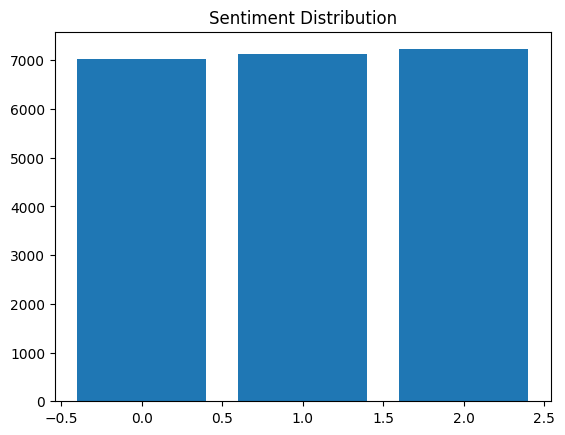

In [ ]:
plot_names = combined_df['sentiment'].value_counts().keys()
plot_values = combined_df['sentiment'].value_counts().values

plt.title('Sentiment Distribution')
plt.bar(plot_names, plot_values)

## **Text Preprocessing**

**References**:
https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert#4.-Text-Data-Preprocessing

https://aihub.org/2023/03/30/methods-for-addressing-class-imbalance-in-deep-learning-based-natural-language-processing/

The following steps are done in the text-preprocessing steps:

* Lowercasing ✅
* Contractions Removal ✅
* Emoji Replacement ✅
* Removing special characters (punctuations, currency signs, digits) ✅
* Stopword Removal and Lemmatization ❌

####**Lowercasing**

In [ ]:
combined_df['Content'] = combined_df['Content'].str.lower()

#### **Creating an nlp object for using spacy**

In [ ]:
nlp = spacy.load("en_core_web_lg")

#### **Check Reviews with length less than 2 characters**

In [ ]:
combined_df.loc[combined_df["Content"].str.len() < 2]

,Rating,Content,Source,sentiment
12355,3.0,！,PowerReviews,1
12359,3.0,.,PowerReviews,1
12402,3.0,.,PowerReviews,1
12413,3.0,.,PowerReviews,1
12512,3.0,.,PowerReviews,1
...,...,...,...,...
17740,1.0,f,PowerReviews,0
17926,1.0,s,PowerReviews,0
20810,2.0,p,PowerReviews,0
20927,2.0,8,PowerReviews,0


There are multiple reviews with single length character which does have rating but model can't learn from a single word character reviews. Hence, it better to drop them.

#### **Applying Cleaning Methods** **- Enchanced and more precise functions than the ones in Approach 1 and 2**

#### **Tokenization, Removing Contractions, Emojis, Punctuations, Currencies and Numbers**

In [ ]:
def remove_convert_emoji(text):

    emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)


    if len(text)<2:
        emoji_dict = demoji.findall(text)
        for key, value in emoji_dict.items():
            return value

    else:
        demoji.findall(text)

        values_list  = []

        for keys, values in demoji.findall(text).items():
            values_list.append(values)

        if "star" in values_list:
            return re.sub(emoj, 'star', text)

        emoji_removed = re.sub(emoj, '', text)
        return emoji_removed

In [ ]:
%%time
combined_df["cleaned_emoji"] = combined_df["Content"].apply(remove_convert_emoji)

CPU times: user 1min 37s, sys: 288 ms, total: 1min 37s
Wall time: 1min 38s


In [ ]:
combined_df["cleaned_emoji"].isnull().sum()

47

In [ ]:
combined_df.isnull().sum()

Rating            0
Content           0
Source            0
sentiment         0
cleaned_emoji    47
dtype: int64

In [ ]:
combined_df = combined_df.dropna()

In [ ]:
def remove_contractions(text):

    # Removing Contractions
    expanded_text = []
    for word in text.split():
        expanded_text.append(contractions.fix(word))

    expanded_text = ' '.join(expanded_text)
    return expanded_text

In [ ]:
%%time
combined_df["contractions_removed"] = combined_df["cleaned_emoji"].apply(remove_contractions)

CPU times: user 4.87 s, sys: 24.2 ms, total: 4.89 s
Wall time: 5.06 s


#### **Applying another cleaning function, removing square brackets, links and words containing numbers and punctuations if any are left after the first round**

In [ ]:
def regex(text):
    text = text.lower() #lowercases the string
    text = re.sub(r"\.{2,}",".", text) #removes trailing ...
    text = re.sub(r"\!{2,}","!", text) #removes trailing !!!
    text = re.sub(r"\+{2,}","", text) #removes trailing +++
    text = re.sub(r"\?{2,}","?", text) #removes trailing ???
    text = re.sub(r"\_{2,}"," ", text) #removes trailing ___
    text = re.sub(r"[\[\]]", '', text) #removes [ or ]
    text = re.sub(r"\(.*?\)", '', text) #removes (text)
    text = re.sub(r'["“”]', '', text) #removes quotation maeks ""
    text = re.sub(r'(\w)\1+', r'\1\1', text) #removes repeating characters and repaces it with 2 occurances
    text = re.sub(r'\*', '', text) #removes *
    text = re.sub(r"\s*([.])\s*", '. ', text) #removes whitespaces for .
    text = re.sub(r"\s*([,])\s*", ', ', text) #removes whitespaces for ,
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #removes links

    return text

In [ ]:
%%time
combined_df["regex"] = combined_df["contractions_removed"].apply(regex)

CPU times: user 1.86 s, sys: 12.9 ms, total: 1.87 s
Wall time: 1.88 s


In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment,cleaned_emoji,contractions_removed,regex
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet. don't have the item,not sure yet. do not have the item,not sure yet. do not have the item
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,it would be nice if i could finish shopping be...,it would be nice if i could finish shopping be...
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,"seemless, so far. need to wait for delivery to...","seemless, so far. need to wait for delivery to...","seemless, so far. need to wait for delivery to..."
3,4.0,website slow.,PowerReviews,2,website slow.,website slow.,website slow.
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,easy to use online system,easy to use online system


#### **Check reviews again with length < 2**

In [ ]:
combined_df.loc[combined_df["regex"].str.len() < 2]

,Rating,Content,Source,sentiment,cleaned_emoji,contractions_removed,regex
12392,3.0,??,PowerReviews,1,??,??,?
12654,3.0,"""""",PowerReviews,1,"""""","""""",
12980,3.0,!!,PowerReviews,1,!!,!!,!
17696,1.0,:[,PowerReviews,0,:[,:[,:


**After dropping emojis, contractions and many other unwanted patterns, there are still some special characters left as a single character review in the dataset. Proceeding to drop them.**

In [ ]:
combined_df = combined_df.drop(combined_df.loc[combined_df["regex"].str.len() < 2].index)

In [ ]:
combined_df = combined_df.dropna()

###**Proceding to check 2 character reviews**

In [ ]:
combined_df.loc[combined_df["regex"].str.len() < 3]

,Rating,Content,Source,sentiment,cleaned_emoji,contractions_removed,regex
2026,4.0,............,Trustpilot,2,............,............,.
3361,4.0,aaaaaaaaaaaaaaaaaaa,Trustpilot,2,aaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaa,aa
12347,3.0,ok,PowerReviews,1,ok,ok,ok
12354,3.0,ok,PowerReviews,1,ok,ok,ok
12398,3.0,ok,PowerReviews,1,ok,ok,ok
...,...,...,...,...,...,...,...
20779,2.0,ok,PowerReviews,0,ok,ok,ok
20918,2.0,mmm,PowerReviews,0,mmm,mmm,mm
20959,2.0,ok,PowerReviews,0,ok,ok,ok
21082,2.0,ooooo,PowerReviews,0,ooooo,ooooo,oo


**As observed, apart from ok, there are still many 2 characters review which makes hard to predict sentiment as they are not meaningful grammatical words. Proceeding to find and remove them accordingly.**

In [ ]:
# Strip unwanted spaces on left or right
def strip_text(text):
    return text.strip()

In [ ]:
combined_df["regex"] = combined_df["regex"].apply(strip_text)

In [ ]:
combined_df = combined_df.drop(combined_df.loc[combined_df["regex"].str.len() < 2].index)

In [ ]:
combined_df.loc[combined_df["regex"].str.len() < 3].regex.value_counts()

regex
ok    86
xx     3
na     2
zz     2
rr     2
      ..
go     1
jh     1
gg     1
jj     1
oo     1
Name: count, Length: 18, dtype: int64

In [ ]:
combined_df.loc[(combined_df["regex"] != "ok") & (combined_df["regex"].str.len() < 3)].value_counts()

Rating  Content                                            Source        sentiment  cleaned_emoji                                      contractions_removed                               regex
3.0     xxx                                                PowerReviews  1          xxx                                                xxx                                                xx       2
        na                                                 PowerReviews  1          na                                                 na                                                 na       2
1.0     0k                                                 PowerReviews  0          0k                                                 0k                                                 0k       1
        23                                                 PowerReviews  0          23                                                 23                                                 23       1
3.0     zzzzzzzzzzzz

In [ ]:
combined_df = combined_df.drop(combined_df.loc[(combined_df["regex"] != "ok") & (combined_df["regex"].str.len() < 3)].index)

#### **Check reviews again with length < 3**

In [ ]:
combined_df.loc[combined_df["regex"].str.len() < 3]

,Rating,Content,Source,sentiment,cleaned_emoji,contractions_removed,regex
12347,3.0,ok,PowerReviews,1,ok,ok,ok
12354,3.0,ok,PowerReviews,1,ok,ok,ok
12398,3.0,ok,PowerReviews,1,ok,ok,ok
12483,3.0,ok,PowerReviews,1,ok,ok,ok
12527,3.0,ok,PowerReviews,1,ok,ok,ok
...,...,...,...,...,...,...,...
14341,3.0,ok,PowerReviews,1,ok,ok,ok
14342,3.0,ok,PowerReviews,1,ok,ok,ok
17648,1.0,ok,PowerReviews,0,ok,ok,ok
20779,2.0,ok,PowerReviews,0,ok,ok,ok


#### **Checking reviews with length 3**

In [ ]:
combined_df.loc[combined_df["regex"].str.len() < 4].regex.value_counts()

regex
ok     86
bad     2
meh     1
fab     1
oky     1
kjh     1
eer     1
goo     1
:((     1
gay     1
Name: count, dtype: int64

### **Removing Meaningless Special Characters**

In [ ]:
def remove_special_char(text):
  if len(text)<4:
    text = text.strip()
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
  return text

In [ ]:
combined_df['regex'] = combined_df['regex'].apply(remove_special_char)

In [ ]:
combined_df.loc[combined_df["regex"].str.len() < 10].regex.value_counts()

regex
ok          86
good        36
fine        20
none        10
great       10
            ..
fab          1
cheers       1
bhhjhj       1
uhgg         1
thankyou     1
Name: count, Length: 111, dtype: int64

In [ ]:
combined_df['regex'] = combined_df['regex'].astype(str)

In [ ]:
combined_df.drop(columns = ['cleaned_emoji',	'contractions_removed'], inplace = True)

In [ ]:
combined_df.head()

,Rating,Content,Source,sentiment,regex
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet. do not have the item
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,"seemless, so far. need to wait for delivery to..."
3,4.0,website slow.,PowerReviews,2,website slow.
4,4.0,easy to use online system,PowerReviews,2,easy to use online system


### **Checking for Duplicates**

In [ ]:
duplicate = combined_df[combined_df.duplicated('regex')]

In [ ]:
duplicate

,Rating,Content,Source,sentiment,regex
196,4.0,very good.,PowerReviews,2,very good.
270,4.0,straight forward,PowerReviews,2,straight forward
359,4.0,great service,PowerReviews,2,great service
450,4.0,good as always,PowerReviews,2,good as always
526,4.0,quick and easy,PowerReviews,2,quick and easy
...,...,...,...,...,...
21154,2.0,go away,PowerReviews,0,go away
21249,2.0,very slow website,PowerReviews,0,very slow website
21288,2.0,good.,PowerReviews,0,good.
21356,2.0,excellent,PowerReviews,0,excellent


**There are multiple records which are duplicate which also make ML models confusing to train. Proceeding to remove them.**

### **Creating a new Dataframe with duplicates removed**

In [ ]:
df_dup_removed = combined_df.drop_duplicates(subset=['Content', 'regex'])

In [ ]:
df_dup_removed

,Rating,Content,Source,sentiment,regex
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet. do not have the item
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,"seemless, so far. need to wait for delivery to..."
3,4.0,website slow.,PowerReviews,2,website slow.
4,4.0,easy to use online system,PowerReviews,2,easy to use online system
...,...,...,...,...,...
21373,2.0,not ideal. i phoned to ask about free 24hr del...,PowerReviews,0,not ideal. i phoned to ask about free 24hr del...
21374,2.0,"depends, last time 'next day' delivery wasn't ...",PowerReviews,0,"depends, last time 'next day' delivery was not..."
21375,2.0,descriptions of products on the site is very g...,PowerReviews,0,descriptions of products on the site is very g...
21376,2.0,not the most user friendly website...,PowerReviews,0,not the most user friendly website.


**Checking if duplicates still remain**

In [ ]:
duplicate = df_dup_removed[df_dup_removed.duplicated('regex')]

In [ ]:
duplicate

,Rating,Content,Source,sentiment,regex
1227,4.0,quick and easy.,PowerReviews,2,quick and easy.
1345,4.0,very good...,PowerReviews,2,very good.
2008,4.0,good service,Trustpilot,2,good service
4096,5.0,great as always,PowerReviews,2,great as always
4308,5.0,"very good , thank you",PowerReviews,2,"very good, thank you"
...,...,...,...,...,...
20419,2.0,i bought a dji care package for my drone one d...,Trustpilot,0,i bought a dji care package for my drone one d...
20434,2.0,long time customer and this purchase was poor ...,Trustpilot,0,long time customer and this purchase was poor ...
20439,2.0,my experience was lowered to 2 stars as the it...,Trustpilot,0,my experience was lowered to 2 stars as the it...
20508,2.0,"i recently gave wex a review of 4 starts, 4 da...",Trustpilot,0,"i recently gave wex a review of 4 starts, 4 da..."


**Very few duplicates remain, which is fine for now, checking the distribution after cleaning**

In [ ]:
fig = px.histogram(df_dup_removed,x="sentiment", color='sentiment', title = 'Sentiment Distribution', labels={'x': 'sentiment', 'y': 'frequency'})
fig.update_layout(bargap=0.2)
fig.show()

**The dataset seems to be much more balanced. Proceeding to lemmatize even more**

#### **Adding a Word Count column**
This is to calculate the no. of words in every review

In [ ]:
df_dup_removed['word_count'] = df_dup_removed['regex'].apply(lambda x: len(str(x).split()))

In [ ]:
df_dup_removed.head()

,Rating,Content,Source,sentiment,regex,word_count
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet. do not have the item,8
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,14
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,"seemless, so far. need to wait for delivery to...",12
3,4.0,website slow.,PowerReviews,2,website slow.,2
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,5


#### **Stopword Removal and Lemmatization**

In [ ]:
def lemmatization(text):
  doc = nlp(text)
  new_string = []

  for word in doc:
    if word.is_stop:
      continue

    new_string.append(word.lemma_)
  return ' '.join(new_string)

In [ ]:
%%time
df_dup_removed['cleaned_text'] = df_dup_removed['regex'].apply(lemmatization)

CPU times: user 6min 31s, sys: 1.17 s, total: 6min 32s
Wall time: 6min 37s


#### **Text without Stopwords and Lemmatized**

In [ ]:
df_dup_removed['regex'][10]

'good clear website, easy to use'

#### **Text WITH Stopwords and Lemmatized**

In [ ]:
df_dup_removed['cleaned_text'][10]

'good clear website , easy use'

In [ ]:
df_dup_removed

,Rating,Content,Source,sentiment,regex,word_count,cleaned_text
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet. do not have the item,8,sure . item
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,14,nice finish shopping hit .
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,"seemless, so far. need to wait for delivery to...",12,"seemless , far . need wait delivery 5 star"
3,4.0,website slow.,PowerReviews,2,website slow.,2,website slow .
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,5,easy use online system
...,...,...,...,...,...,...,...
21373,2.0,not ideal. i phoned to ask about free 24hr del...,PowerReviews,0,not ideal. i phoned to ask about free 24hr del...,188,ideal . phone ask free 24hr delivery £ 120 ord...
21374,2.0,"depends, last time 'next day' delivery wasn't ...",PowerReviews,0,"depends, last time 'next day' delivery was not...",16,"depend , time ' day ' delivery day . amazon prime"
21375,2.0,descriptions of products on the site is very g...,PowerReviews,0,descriptions of products on the site is very g...,57,description product site good . purchase proce...
21376,2.0,not the most user friendly website...,PowerReviews,0,not the most user friendly website.,6,user friendly website .


**Note / Observation**: After comparing the result after applying lemmatization, STOP words remove the words which change the complete meaning of the review / sentence.

For eg:-

**Original Review**: good camera , no free delivery why ?????

**Lemmatized Review**: good camera , free delivery ?

As per above observation, undo-ing lemmatization

In [ ]:
df_dup_removed.drop(columns = ['cleaned_text'], inplace = True)

In [ ]:
df_dup_removed.head()

,Rating,Content,Source,sentiment,regex,word_count
0,4.0,not sure yet. don't have the item,PowerReviews,2,not sure yet. do not have the item,8
1,4.0,it would be nice if i could finish shopping be...,PowerReviews,2,it would be nice if i could finish shopping be...,14
2,4.0,"seemless, so far. need to wait for delivery to...",PowerReviews,2,"seemless, so far. need to wait for delivery to...",12
3,4.0,website slow.,PowerReviews,2,website slow.,2
4,4.0,easy to use online system,PowerReviews,2,easy to use online system,5


Also, dropping Content column which is the original review column and replaxing regex column with Content to pass to ML models to train.

In [ ]:
df_dup_removed.drop(columns = ['Content'], inplace = True)

In [ ]:
df_dup_removed = df_dup_removed.rename(columns={'regex': 'Content'})

In [ ]:
df_dup_removed.head()

,Rating,Source,sentiment,Content,word_count
0,4.0,PowerReviews,2,not sure yet. do not have the item,8
1,4.0,PowerReviews,2,it would be nice if i could finish shopping be...,14
2,4.0,PowerReviews,2,"seemless, so far. need to wait for delivery to...",12
3,4.0,PowerReviews,2,website slow.,2
4,4.0,PowerReviews,2,easy to use online system,5


### **Save Cleaned Combined Dataframe to CSV for future**

In [ ]:
df_dup_removed.to_csv(os.getcwd() + '/CFA_Wex/MyDrive/cleaned_reviews_approach3.csv', index=False)

## **Plots**

Reference: https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert#2.-General-EDA

#### **Sentiment Distribution Plot**

In [ ]:
df_dup_removed['sentiment'].value_counts()

sentiment
2    7053
0    6954
1    6741
Name: count, dtype: int64

In [ ]:
df_dup_removed['sentiment'].value_counts(normalize=True)

sentiment
2    0.339936
0    0.335165
1    0.324899
Name: proportion, dtype: float64

* ~33% of the sentiments are of Positive
* ~33% of the sentiments are of Neutral
* ~33% of the sentiments are of Negative

In [ ]:
fig = px.histogram(df_dup_removed,x="sentiment", color='sentiment', title = 'Sentiment Distribution', labels={'x': 'sentiment', 'y': 'frequency'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Creating Dataframes for Positive, Negative and Neutral Sentiments**

In [ ]:
pos = df_dup_removed[df_dup_removed['sentiment']==2]
neg = df_dup_removed[df_dup_removed['sentiment']==0]
neutral = df_dup_removed[df_dup_removed['sentiment']==1]

#### **Positive Rating Reviews Word count**

In [ ]:
fig = px.histogram(pos,x="word_count", title = 'Positive Rating Word Count', labels={'word_count': 'review length'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Neutral Rating Reviews Word count**

In [ ]:
fig = px.histogram(neutral,x="word_count", title = 'Neutral Rating Word Count', labels={'word_count': 'review length'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Negative Rating Reviews Word count**

In [ ]:
fig = px.histogram(neg,x="word_count", title = 'Negative Rating Word Count', labels={'word_count': 'review length'})
fig.update_layout(bargap=0.2)
fig.show()

#### **Word Frequency Plot**
**Plotting** the most common words in the dataset

In [ ]:
count = 50

In [ ]:
word_count = Counter()
for text in df_dup_removed['Content']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'})
fig.show()

#### **Top 50 Words in Positive sentiments**

In [ ]:
word_count = Counter()
for text in pos['Content']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'}, color_discrete_sequence =['green'])
fig.show()

#### **Top 50 Words in Neutral sentiments**

In [ ]:
word_count = Counter()
for text in neutral['Content']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'}, color_discrete_sequence =['orange'])
fig.show()

#### **Top 50 Words in Negative sentiments**

In [ ]:
word_count = Counter()
for text in neg['Content']:
  for word in text.split():
    word_count[word] +=1

freq_list = word_count.most_common(count)

words = []
freq = []
for tuple_item in freq_list:
  words.append(tuple_item[0])
  freq.append(tuple_item[1])
words = np.array(words)
freq = np.array(freq)

fig = px.bar(x= words, y=freq, title = 'Word Frequency', labels ={'x':'Word', 'y':'Frequency'}, color_discrete_sequence =['orangered'])
fig.show()

#### **Box Plotting Sentiments**

In [ ]:
fig = px.box(df_dup_removed,x="sentiment", y = 'word_count', title = 'Box plot for Sentiments',points="all", color='sentiment', labels={'word_count':'frequency'})
fig.show()

#### **Wordcloud**

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for val in df_dup_removed['Content']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

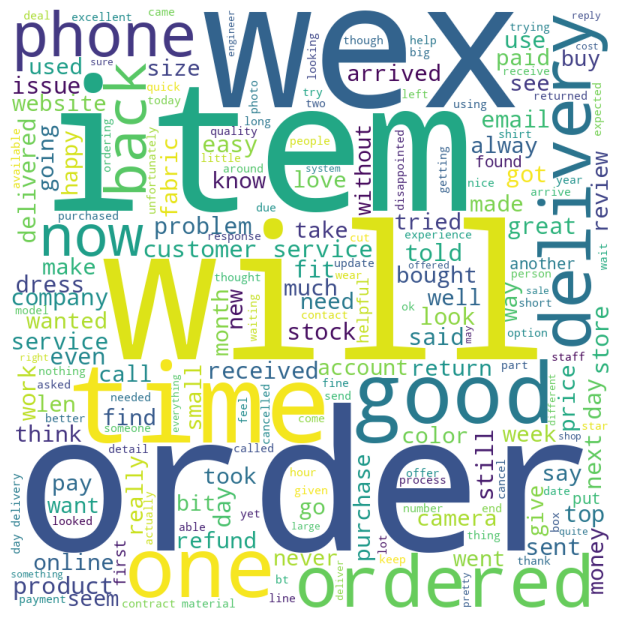

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## **Model Building Pipeline**

**References:-**

https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.freecodecamp.org/news/machine-learning-pipeline/

In [ ]:
import pickle


class ModelTraining(object):
  def __init__(self):
    self.df = pd.read_csv(path + '/cleaned_reviews_approach3.csv')
    self.path = os.getcwd() + '/CFA_Wex/MyDrive/'

    # Splitting Data into Train / Test / Validate sets in constructor only to use global (self) variables in all functions
    print("Current Rating Distribution after data cleaning and pre-processing")
    print(self.df['Rating'].value_counts())

    X = self.df.Content.values.astype('U')
    y = self.df.sentiment

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)
    print("Input Variables train / test total records")
    print(self.X_train.shape)
    print(self.X_test.shape)
    print("Target Variable -> Sentiment train / test count distribution")
    self.y_train.value_counts(), self.y_test.value_counts()

    print("Data splitted successfully")
    print()

  def model_building(self):
      models = [LogisticRegression(random_state=1),
          RandomForestClassifier(random_state=1),
          KNeighborsClassifier(n_neighbors = 5),
          SVC(random_state=1),
          MultinomialNB()]
      results = []
      f1scores = []
      print("Calculating Accuracies and F1 Scores")
      for model in models:
        pipeline = Pipeline([
          ('vectorizer_tri_grams', TfidfVectorizer()),
          ('model', model)])
        pipeline.fit(self.X_train, self.y_train)
        scores = pipeline.score(self.X_test, self.y_test)
        predicted_val = pipeline.predict(self.X_test)
        f1_scores = f1_score(self.y_test, predicted_val, average='macro')
        results.append(scores)
        f1scores.append(f1_scores)
      print()
      for model, accuracy, f1 in zip(models, results, f1scores):
        print(f"Model: {model} >> Accuracy: {round(np.mean(accuracy), 3)}   |  F1 Score: {round(np.mean(f1), 3)}")

      print()
      return results, f1scores

  def hyper_param_tuning(self):
    print("Started Hyper Parameter Tuning using GridSearchCV")
    param_grid_lr = {
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear'],
        'model__max_iter': [100]
        }

    param_grid_rf = {
        'model__criterion': ['gini'],
        'model__min_samples_split': [4]
        }

    param_grid_svc = {
        'model__C': [1, 10],
        'model__gamma': [0.01, 0.001],
        'model__kernel': ['rbf']
        }

    param_grid = [param_grid_lr, param_grid_rf, param_grid_svc]
    models_final = [LogisticRegression(random_state=1),
                    RandomForestClassifier(random_state=1),
                    SVC(random_state=1)]

    best_params = []
    best_estimator = []

    for model, grid_params in zip(models_final, param_grid):
      print(f"Model: {model}")
      clf_pipeline = Pipeline(steps =[('vectorizer_tri_grams', TfidfVectorizer()),('model', model)])
      gs= GridSearchCV(clf_pipeline, grid_params, cv=5, scoring='accuracy', refit=True,verbose=3)
      gs.fit(self.X_train, self.y_train)
      best_params.append(gs.best_params_)
      best_estimator.append(gs.best_estimator_)

    print()
    return best_params, best_estimator

  def best_hyper_params(self):
    best_params, best_estimator = self.hyper_param_tuning()
    abrv = ['lr','rf','svc']
    for a, p, e in zip(abrv, best_params, best_estimator):
      print(f"""Model : {a.upper()}
      Best Parameter : {p}
      Best Estimator : {e} \n""")
    print()

  def calculate_display_results(self):
    print("Time for results")
    self.svc_result()
    self.logistic_regression_result()

  def svc_result(self):
    print("SVC Result")
    svc = SVC(C=10, gamma=0.01, kernel= 'rbf', random_state=1)
    model_svc = Pipeline([
        ('vectorizer_tri_grams', TfidfVectorizer()),
        ('model', svc)])

    model_svc.fit(self.X_train, self.y_train)
    predict_svc = model_svc.predict(self.X_test)
    score = model_svc.score(self.X_test, self.y_test)
    print(score)

    # Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(self.y_test, predict_svc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()

    # Classification Report
    print(classification_report(self.y_test, predict_svc, labels=[0, 1, 2]))
    print()

    # Saving SVC model
    filename = self.path + '/model_svc_approach3.sav'
    pickle.dump(model_svc, open(filename, 'wb'))

  def logistic_regression_result(self):
    print("Logistic Regression Result")
    logistic_regression = LogisticRegression(C=1, penalty='l2', max_iter=100, solver='liblinear')

    model_lr = Pipeline([
        ('vectorizer_tri_grams', TfidfVectorizer()),
        ('model', logistic_regression)])

    model_lr.fit(self.X_train, self.y_train)
    predict_lr = model_lr.predict(self.X_test)
    score = model_lr.score(self.X_test, self.y_test)
    print(score)

    # Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(self.y_test, predict_lr)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()

    # Classification Report
    print(classification_report(self.y_test, predict_lr, labels=[0, 1, 2]))
    print()

    # Saving LR model
    filename = self.path + '/model_lr_approach3.sav'
    pickle.dump(model_lr, open(filename, 'wb'))

  def model_training_with_best_hyper_param(self):
    results, f1scores = self.model_building()
    self.best_hyper_params()
    models_hyp = [LogisticRegression(C=1, penalty='l2', max_iter=100, solver='liblinear'),
          RandomForestClassifier(criterion='gini', min_samples_split=4,random_state=1),
          SVC(C=10, gamma=0.01, kernel= 'rbf', random_state=1)]

    models_hyp_names = ['Logistic Regression', 'RandomForest Classifier', 'SVC']
    results_hyper = []
    f1scores_hyper = []
    model_stored = []

    for model in models_hyp:
      pipeline = Pipeline([
        ('vectorizer_tri_grams', TfidfVectorizer()),
        ('model', model)])
      pipeline.fit(self.X_train, self.y_train)
      scores = pipeline.score(self.X_test, self.y_test)
      predicted_val = pipeline.predict(self.X_test)
      f1_scores = f1_score(self.y_test, predicted_val, average='macro')
      results_hyper.append(scores)
      f1scores_hyper.append(f1_scores)

    for model, accuracy, f1 in zip(models_hyp_names, results_hyper, f1scores_hyper):
      print(f"""Model: {model}
                                  Accuracy: {round(np.mean(accuracy), 4)}
                                  F1 Score: {round(np.mean(f1), 4)}\n""")

    print()
    f1scores = [f1scores[0], f1scores[1], f1scores[4]]
    results = [results[0], results[1], results[4]]

    #Creating list to store F1 scores with hyperparameters
    df_plot = pd.DataFrame( {"Models": ["Logistic Regression",
                      "Random Forest",
                      "SVC"]*2,
              "F1 Scores": f1scores + f1scores_hyper,
              "Accuracy": results + results_hyper,
              "Normal/Hyper":(["Normal"]*3+["Hypertuned"]*3)
            })
    print(df_plot)
    print()


if __name__ == "__main__":
  obj = ModelTraining()
  obj.model_training_with_best_hyper_param()
  obj.calculate_display_results()

## **Adding Predictions to the Dataset**

### **Text Cleaning and Pre-processing Pipeline**

In [11]:
class CleanAndPreprocess(object):
  def __init__(self):
    self.path = os.getcwd() + '/CFA_Wex/MyDrive/'
    self.df = pd.read_csv(path + '/cleaned_reviews_approach3.csv') # File that needs to be cleaned before testing ML model
    self.nlp = spacy.load("en_core_web_lg") # Invoking nlp large pre-trained model

  def create_sentiment_labels(self, rating):
    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

  def apply_sentiment_to_test_data(self):
    # Apply to the dataset
    self.df['Sentiment'] = self.df['Rating'].apply(self.create_sentiment_labels)

  def check_mandatory_columns(self):
    columns_to_check = ['Rating', 'Content', 'Sentiment']
    # Check if the columns exist in the DataFrame
    existing_columns = [col for col in columns_to_check if col in self.df.columns]
    missing_columns = set(columns_to_check) - set(existing_columns)
    if missing_columns:
      if 'Sentiment' in missing_columns:
        print("Sentiment column not found. Creating sentiment labels")
        self.apply_sentiment_to_test_data()
        existing_columns = [col for col in columns_to_check if col in self.df.columns]
        return existing_columns
      else:
        print(f"Following mandatory columns are missing from the DataFrame: {missing_columns}")
        return False
    else:
      print("Found all mandatory columns. Proceeding..")
      return existing_columns

  def find_and_drop_missing_records(self):
        existing_columns = self.check_mandatory_columns()
        if existing_columns:
          # Check for missing values in the existing columns
          missing_values = self.df[existing_columns].isnull().sum()
          print("Missing values before dropping rows:")
          print(missing_values)
          df_cleaned = self.df.dropna(subset=existing_columns)
          # Verify that there are no more missing values in those columns
          missing_values_after = df_cleaned[existing_columns].isnull().sum()
          print("\nMissing values after dropping rows:")
          print(missing_values_after)
          print("\nShape of the DataFrame before dropping rows:", self.df.shape)
          print("Shape of the DataFrame after dropping rows:", df_cleaned.shape)
        else:
          print("Mandatory columns not found in test data file. Exiting..")
          exit(0)

  def reviews_lowercasing(self):
    self.df['Content'] = self.df['Content'].str.lower()
    print("All reviews lowercased successfully")

  def find_emoji(self, text):
    emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)

    if len(str(text))<2:
        emoji_dict = demoji.findall(text)
        for key, value in emoji_dict.items():
            return value
    else:
        demoji.findall(str(text))
        values_list  = []
        for keys, values in demoji.findall(str(text)).items():
            values_list.append(values)

        if "star" in values_list:
            return re.sub(emoj, 'star', str(text))

        emoji_removed = re.sub(emoj, '', str(text))
        return emoji_removed

  def emoji_remove_replace(self):
    self.df["cleaned_emoji"] = self.df["Content"].apply(self.find_emoji)
    emojis_found = self.df["cleaned_emoji"].isnull().sum()
    print(f"Emoji Records to be removed: {emojis_found}")
    self.df = self.df.dropna()
    print("Emojis, Symbols, Chinese Chracters, Flags etc. removed successfully")

  def find_contractions(self, text):
    # Removing Contractions
    expanded_text = []
    for word in text.split():
        expanded_text.append(contractions.fix(word))

    expanded_text = ' '.join(expanded_text)
    return expanded_text

  def contractions_removal(self):
    self.df["contractions_removed"] = self.df["cleaned_emoji"].apply(self.find_contractions)
    print("Contractions removed successfully")

  def find_brackets_links_punctuations(self, text):
    text = text.lower() #lowercases the string
    text = re.sub(r"\.{2,}",".", text) #removes trailing ...
    text = re.sub(r"\!{2,}","!", text) #removes trailing !!!
    text = re.sub(r"\+{2,}","", text) #removes trailing +++
    text = re.sub(r"\?{2,}","?", text) #removes trailing ???
    text = re.sub(r"\_{2,}"," ", text) #removes trailing ___
    text = re.sub(r"[\[\]]", '', text) #removes [ or ]
    text = re.sub(r"\(.*?\)", '', text) #removes (text)
    text = re.sub(r'["“”]', '', text) #removes quotation maeks ""
    text = re.sub(r'(\w)\1+', r'\1\1', text) #removes repeating characters and repaces it with 2 occurances
    text = re.sub(r'\*', '', text) #removes *
    text = re.sub(r"\s*([.])\s*", '. ', text) #removes whitespaces for .
    text = re.sub(r"\s*([,])\s*", ', ', text) #removes whitespaces for ,
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #removes links

    return text

  def brackets_links_punctuations_removal(self):
    self.df["regex"] = self.df["contractions_removed"].apply(self.find_brackets_links_punctuations)
    self.df = self.df.drop(self.df.loc[self.df["regex"].str.len() < 2].index)
    self.df = self.df.dropna()
    print("Brackets, Links, Numbers in text or Punctuations removed succesfully")

  def find_unwanted_spaces(self, text):
    return text.strip()

  def strip_unwanted_spaces(self):
    self.df["regex"] = self.df["regex"].apply(self.find_unwanted_spaces)
    self.df = self.df.drop(self.df.loc[self.df["regex"].str.len() < 2].index)
    self.df.loc[self.df["regex"].str.len() < 3].regex.value_counts()
    self.df.loc[(self.df["regex"] != "ok") & (self.df["regex"].str.len() < 3)].value_counts()
    self.df = self.df.drop(self.df.loc[(self.df["regex"] != "ok") & (self.df["regex"].str.len() < 3)].index)
    self.df[self.df["regex"].str.len() < 3]
    print("Unwanted trailing spaces removed successfully")

  # Remove more meaningless special characters
  def find_special_char(self, text):
    if len(text)<4:
      text = text.strip()
      text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

  def special_char_removal(self):
    self.df['regex'] = self.df['regex'].apply(self.find_special_char)
    self.df.loc[self.df["regex"].str.len() < 10].regex.value_counts()
    self.df['regex'] = self.df['regex'].astype(str)
    self.df.drop(columns = ['cleaned_emoji',	'contractions_removed'], inplace = True)
    print("Special Characters removed successfully")

  def find_drop_duplicates(self, cleaned=False):
    if cleaned:
      print("\nShape of the DataFrame before dropping duplicate rows:", self.df.shape)
      duplicate = self.df[self.df.duplicated('regex')]
      self.df = self.df.drop_duplicates(subset=['Content', 'regex'])
      print("Duplicate records removed successfully from pre-processed data")
      print("\nShape of the DataFrame after dropping duplicate rows:", self.df.shape)
    else:
      print("\nShape of the DataFrame before dropping duplicate rows:", self.df.shape)
      duplicate = self.df[self.df.duplicated('Content')]
      self.df = self.df.drop_duplicates(subset=['Content'])
      print("Duplicate records removed successfully from raw data")
      print("\nShape of the DataFrame after dropping duplicate rows:", self.df.shape)

  def drop_regex_column(self):
    # Replace Content with regex column
    self.df.drop(columns = ['Content'], inplace = True)
    self.df = self.df.rename(columns={'regex': 'Content'})
    print("Regex column dropped successfully")

  def save_preprocessed_test_data(self):
    self.df.to_csv(path + '/cleaned_test_data_approach3.csv', index=False)
    print("Test Data Pre-processed and saved successfully.")
    print("Please check cleaned_test_data_approach3.csv")

  def main(self, model_type="ML"):
    if model_type.upper() in ["ML", "MACHINE LEARNING", "SUPERVISED"]:
      print("Initiating Pre-processing for ML modelling")
      print("######################### STEP 1 #########################")
      print("Drop Missing records")
      obj.find_and_drop_missing_records()
      print("######################### STEP 2 #########################")
      print("Lowercase the reviews text")
      obj.reviews_lowercasing()
      print("######################### STEP 3 #########################")
      print("Drop Duplicate records from Raw Data ")
      obj.find_drop_duplicates(cleaned=False)
      print("######################### STEP 4 #########################")
      print("Remove Emojis and other Symbols")
      obj.emoji_remove_replace()
      print("######################### STEP 5 #########################")
      print("Remove Contractions")
      obj.contractions_removal()
      print("######################### STEP 6 #########################")
      print("Remove Brackets, Links and Punctuations")
      obj.brackets_links_punctuations_removal()
      print("######################### STEP 7 #########################")
      print("Remove unwanted trailing spaces")
      obj.strip_unwanted_spaces()
      print("######################### STEP 8 #########################")
      print("Remove Special Characters")
      obj.special_char_removal()
      print("######################### STEP 9 #########################")
      print("Drop Duplicate records from Pre-processed Data")
      obj.find_drop_duplicates(cleaned=True)
      print("######################### STEP 10 #########################")
      print("Drop all other unwanted columns")
      obj.drop_regex_column()
      print("Save Pre-processed data")
      print("######################### STEP 11 #########################")
      obj.save_preprocessed_test_data()

    elif model_type in ["BERT"]:
      print("To be done")
    else:
      print(f"Invalid model type: {model_type}. Please provide correct model type.")


if __name__ == "__main__":
  obj = CleanAndPreprocess()
  obj.main(model_type="ML")

Initiating Pre-processing for ML modelling
######################### STEP 1 #########################
Drop Missing records
Found all mandatory columns. Proceeding..
Missing values before dropping rows:
Rating       0
Content      1
Sentiment    0
dtype: int64

Missing values after dropping rows:
Rating       0
Content      0
Sentiment    0
dtype: int64

Shape of the DataFrame before dropping rows: (20748, 5)
Shape of the DataFrame after dropping rows: (20747, 5)
######################### STEP 2 #########################
Lowercase the reviews text
All reviews lowercased successfully
######################### STEP 3 #########################
Drop Duplicate records from Raw Data 

Shape of the DataFrame before dropping duplicate rows: (20748, 5)
Duplicate records removed successfully from raw data

Shape of the DataFrame after dropping duplicate rows: (20704, 5)
######################### STEP 4 #########################
Remove Emojis and other Symbols
Emoji Records to be removed: 0
Emojis

### **Model Prediction Pipeline**

In [12]:
import pickle

class ModelPrediction(object):
  def __init__(self):
    self.path = os.getcwd() + '/CFA_Wex/MyDrive/'
    self.df = pd.read_csv(path + '/cleaned_test_data_approach3.csv') # Pre-processed test data to pass to saved ML models for prediction

  def loading_saved_model(self, model_type="SVC"):
    # Load the model from the file
    if model_type.upper() in ["SVC", "SUPPORT VECTOR MACHINE"]:
      print("Loading saved SVC model")
      filename = self.path + '/model_svc_approach3.sav'
      model_svc = pickle.load(open(filename, 'rb'))
      print(f"{model_type} model loaded successfully")
      return model_svc

    elif model_type.upper() in ["LR", "LOGISTIC REGRESSION"]:
      print("Loading saved LR model")
      filename = self.path + '/model_lr_approach3.sav'
      model_lr = pickle.load(open(filename, 'rb'))
      print(f"{model_type} model loaded successfully")
      return model_lr

    else:
      print(f"{model_type} not found in saved models. Please check.")

  def fetch_model_predictions(self, model_type="svc"):
    get_loaded_model = self.loading_saved_model(model_type=model_type)
    X = self.df.Content.values.astype('U')
    predictions = get_loaded_model.predict(X)
    self.df['Prediction'] = predictions
    print(self.df.head())
    print(self.df['Sentiment'].value_counts())
    print(self.df['Prediction'].value_counts())

  def actual_vs_prediction(self):
    names_sent = self.df['Sentiment'].value_counts().keys()
    values_sent = self.df['Sentiment'].value_counts().values

    names_pred = self.df['Prediction'].value_counts().keys()
    values_pred = self.df['Prediction'].value_counts().values

    # Create the plot
    fig = go.Figure(data=[
        go.Bar(
            name='True Labels',
            x=names_sent,
            y=values_sent,
            text=values_sent,
            textposition='auto'
        ),
        go.Bar(
            name='Predicted Labels',
            x=names_pred,
            y=values_pred,
            text=values_pred,
            textposition='auto'
        )
    ])

    # Customize layout
    fig.update_layout(
        title='True vs Predicted Labels',
        xaxis_title='Labels',
        yaxis_title='Values',
        barmode='group'
    )

    fig.show()

  def main(self, model_type="svc"):
    print("Initiating Model Prediction Pipeline")
    print("######################### STEP 1 #########################")
    print("Load model & Fetch Predictions")
    self.fetch_model_predictions(model_type=model_type)
    print("######################### STEP 2 #########################")
    print("Actual vs Prediction Histogram Graph")
    self.actual_vs_prediction()
    print("######################### STEP 3 #########################")
    print("Save Predictions")
    # Replace values / labels in the 'Prediction' column with actual Sentiments labels
    self.df['Prediction'] = self.df['Prediction'].replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
    self.df.to_csv(self.path + '/final_ml_predictions_approach3.csv', index = False)
    print("Predictions saved. Please check final_ml_predictions_approach3.csv")


if __name__ == "__main__":
  obj = ModelPrediction()
  obj.main(model_type="svc")

Initiating Model Prediction Pipeline
######################### STEP 1 #########################
Load model & Fetch Predictions
Loading saved SVC model
svc model loaded successfully
   Rating        Source  Sentiment  word_count  \
0     4.0  PowerReviews          2           8   
1     4.0  PowerReviews          2          14   
2     4.0  PowerReviews          2          12   
3     4.0  PowerReviews          2           2   
4     4.0  PowerReviews          2           5   

                                             Content  Prediction  
0                 not sure yet. do not have the item           0  
1  it would be nice if i could finish shopping be...           2  
2  seemless, so far. need to wait for delivery to...           2  
3                                      website slow.           1  
4                          easy to use online system           2  
Sentiment
2    7040
0    6934
1    6729
Name: count, dtype: int64
Prediction
0    7260
2    6858
1    6585
Name: cou

######################### STEP 3 #########################
Save Predictions
Predictions saved. Please check final_ml_predictions_approach3.csv


### **Issue Type Prediction Pipeline**

In [ ]:
import os
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
from plotly.subplots import make_subplots

class IssueTypePrediction(object):
    def __init__(self):
        self.path = os.getcwd() + '/CFA_Wex/MyDrive/'
        self.df = pd.read_csv(self.path + '/final_ml_predictions_approach3.csv') # Data with predictions

        self.nlp = spacy.load("en_core_web_lg")
        self.matcher = PhraseMatcher(self.nlp.vocab)
        self.issue_phrases = {
            "Electronics": ["laptop", "camera", "lens", "mobile phone", "smartphone",
                            "tripod", "tablet", "headphone", "charger", "battery"],
            "Product": ["product issue", "defective product", "faulty item",
                        "damaged", "damage", "torn", "broken", "break", "gouged"],
            "Packaging": ["packaging", "package", "pack"],
            "Time": ["late", "delayed", "time issue", "too long", "long to arrive"],
            "Delivery": ["delivery issue", "shipment problem", "shipping issue", "arrive",
                         "arrival", "late delivery", "delivery late", "late", "time", "times"],
            "Customer service": ["customer service", "support issue", "service complaint",
                                 "rude", "aggressive", "tone", "behaviour", "nonsense",
                                 "not understand", "staff", "insult"],
            "Payment": ["payment", "pay", "money"],
            "General": ["issue", "problem", "complaint"]
        }
        self.phrase_matcher()

    def phrase_matcher(self):
        for label, phrases in self.issue_phrases.items():
            patterns = [self.nlp.make_doc(text) for text in phrases]
            self.matcher.add(label, patterns)

    def classify_issues(self, text):
        if not isinstance(text, str):
            text = str(text)
        doc = self.nlp(text)
        matches = self.matcher(doc)
        issues = set()
        for match_id, start, end in matches:
            label = self.nlp.vocab.strings[match_id]
            issues.add(label)
        return issues if issues else {"General"}

    def reviews_sentiment_distribution(self):
      df = pd.read_csv(path + '/ml_predictions_with_issue_types.csv')

      filtered_df = df[df['Source'].isin(['Trustpilot', 'PowerReviews'])]
      fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], subplot_titles=['Trustpilot', 'PowerReviews'])

      # Add pie charts to the subplot
      for i, source in enumerate(['Trustpilot', 'PowerReviews']):
          source_data = filtered_df[filtered_df['Source'] == source]['Prediction'].value_counts().reset_index()
          source_data.columns = ['Prediction', 'Count']

          fig.add_trace(
              go.Pie(
                  labels=source_data['Prediction'],
                  values=source_data['Count'],
                  hole=0.4,
                  textinfo='percent+label',
                  hoverinfo='label+value'
              ),
              row=1, col=i+1
          )

      fig.update_layout(title_text='Distribution of Reviews for Trustpilot and PowerReviews')
      fig.show()


    def create_histogram(self, data, title, issues):
      fig = px.histogram(
          data[data['Issues'].isin(issues)],
          x='Issues',
          title=title,
          labels={'Issues': 'Issues', 'count': 'Count'},
          opacity=0.75,
          color_discrete_sequence=['blue'],
          marginal='box'
      )
      return fig

    def issue_distribution(self):
      df = pd.read_csv(path + '/ml_predictions_with_issue_types.csv')

      trustpilot_df = df[df['Source'] == 'Trustpilot']
      power_reviews_df = df[df['Source'] == 'PowerReviews']
      unique_issues = df['Issues'].unique()

      chunks = [unique_issues[i:i+20] for i in range(0, len(unique_issues), 20)]
      figures = []

      for i, chunk in enumerate(chunks):
          fig_trustpilot = self.create_histogram(trustpilot_df, f'Distribution of Issues for Trustpilot - Part {i+1}', chunk)
          figures.append(fig_trustpilot)

      for i, chunk in enumerate(chunks):
          fig_power_reviews = self.create_histogram(power_reviews_df, f'Distribution of Issues for PowerReviews - Part {i+1}', chunk)
          figures.append(fig_power_reviews)

      for fig in figures:
          fig.show()


    def main(self):
        print("Predicting Issue Type")
        filtered_df = self.df[self.df['Prediction'].isin(['Positive', 'Negative', 'Neutral'])]
        filtered_df['Issues'] = filtered_df['Content'].apply(self.classify_issues)
        positive_df = self.df[self.df['Prediction'] == 'Positive']
        final_df = pd.concat([filtered_df, positive_df], ignore_index=True)
        final_df.to_csv(self.path + "/ml_predictions_with_issue_types.csv", index=False)
        print(final_df.head())
        print("Issue Types predicted successfully. Please check ml_predictions_with_issue_types.csv")
        print("Reviews Distribution")
        self.reviews_sentiment_distribution()
        print("Issue Distribution in Trust Pilot and Power Reviews")
        self.issue_distribution()

if __name__ == "__main__":
    obj = IssueTypePrediction()
    obj.main()


#### **Approach 2: Display histogram per unique issue**

In [11]:
df = pd.read_csv(path + '/ml_predictions_with_issue_types.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27561 entries, 0 to 27560
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rating      27561 non-null  float64
 1   Source      27561 non-null  object 
 2   Sentiment   27561 non-null  int64  
 3   word_count  27561 non-null  int64  
 4   Content     27561 non-null  object 
 5   Prediction  27561 non-null  object 
 6   Issues      20703 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ MB


In [13]:
df = df.dropna(subset=['Issues'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20703 entries, 0 to 20702
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rating      20703 non-null  float64
 1   Source      20703 non-null  object 
 2   Sentiment   20703 non-null  int64  
 3   word_count  20703 non-null  int64  
 4   Content     20703 non-null  object 
 5   Prediction  20703 non-null  object 
 6   Issues      20703 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.3+ MB


In [15]:
df['Issues'].value_counts()

Issues
{'General'}                                               12961
{'Delivery'}                                               1602
{'Payment'}                                                 926
{'Electronics'}                                             923
{'Customer service'}                                        770
                                                          ...  
{'Product', 'Delivery', 'Payment'}                            1
{'Packaging', 'Product', 'General'}                           1
{'Payment', 'General', 'Delivery', 'Time'}                    1
{'Product', 'Customer service', 'General', 'Delivery'}        1
{'General', 'Electronics', 'Product', 'Payment'}              1
Name: count, Length: 210, dtype: int64

In [46]:
# Initialize an empty dictionary to store results
source_dict = {}

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    source = row['Source']

    # Check if the source is 'PowerReviews' or 'Trustpilot'
    if source == 'PowerReviews' or source == 'Trustpilot':
        issues_set = eval(row['Issues'])  # Convert string representation to set

        # Check if source is already in the dictionary
        if source in source_dict:
            source_dict[source].extend(issues_set)
        else:
            source_dict[source] = list(issues_set)

# Print or return the resulting dictionary
print(source_dict)


{'PowerReviews': ['General', 'General', 'General', 'General', 'General', 'General', 'Electronics', 'Payment', 'Electronics', 'General', 'General', 'General', 'Electronics', 'General', 'General', 'General', 'General', 'General', 'General', 'Payment', 'General', 'General', 'General', 'Electronics', 'General', 'General', 'General', 'Payment', 'General', 'Payment', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'Electronics', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'Payment', 'Payment', 'General', 'General', 'General', 'Delivery', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'General', 'Customer service', 'General', 'General', 'General', 'General', 'Gener

In [47]:
# Initialize an empty dictionary to store results
source_dict_modified = {}

# Iterate through each key-value pair in source_dict
for source, issues_list in source_dict.items():
    # Initialize a dictionary to count occurrences of each issue
    issue_count = {}

    # Count occurrences of each issue in the list
    for issue in issues_list:
        if issue in issue_count:
            issue_count[issue] += 1
        else:
            issue_count[issue] = 1

    # Assign the modified dictionary to the source_dict_modified
    source_dict_modified[source] = issue_count

# Print or return the resulting modified dictionary
print(source_dict_modified)

{'PowerReviews': {'General': 5289, 'Electronics': 318, 'Payment': 659, 'Delivery': 579, 'Customer service': 148, 'Product': 21, 'Time': 37, 'Packaging': 35}, 'Trustpilot': {'Electronics': 1338, 'General': 2845, 'Packaging': 253, 'Product': 142, 'Customer service': 743, 'Delivery': 1246, 'Time': 183, 'Payment': 326}}


In [48]:
# Create a list to store the figures
figures = []

# Iterate through each key in source_dict_modified
for source, issue_counts in source_dict_modified.items():
    # Extract issues and counts
    issues = list(issue_counts.keys())
    counts = list(issue_counts.values())

    # Create histogram figure for current source
    fig = go.Figure()
    fig.add_trace(go.Bar(x=issues, y=counts, marker_color='royalblue'))

    # Update layout and labels
    fig.update_layout(
        title=f"Issues Count for {source}",
        xaxis_title="Issues",
        yaxis_title="Count",
        showlegend=False
    )

    # Append the figure to the list
    figures.append(fig)

# Display or save the figures
for fig in figures:
    fig.show()